In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,Clojure,629,9180,774,128,Application,21
1,4clojure,Javascript,75,39240,509,29,Application,10
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5
...,...,...,...,...,...,...,...,...
1122,zipkin,Scala,245,54100,589,207,Application,8
1123,zombie,Coffeescript,731,52668,1060,181,Framework,65
1124,zombie,Javascript,46,172564,1026,7,Framework,7
1125,zxcvbn,Coffeescript,58,2085,341,11,Library,5


We define the dataset as an xarray aswell, so it fits PyMC.

In [5]:
df_xa = df.to_xarray()

In [6]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

## Hypothesis 2

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

In [9]:
def standardize_column(variable):
    # Standardize the column
    standardized_column = (variable - variable.mean()) / variable.std()
    
    return standardized_column

In [10]:
df['age_std'] = standardize_column(df['age'])

In [14]:
df['bug_std'] = standardize_column(df['bugs'])

In [8]:
language_idx, languages = pd.factorize(df.language)

In [51]:
with pm.Model() as m_h2:
    alpha = pm.Normal("alpha", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.2, shape=languages.size)
    sigma = pm.Exponential("sigma", 1.0)

    #We add language_ids as mutable data so we can change it later in posterior predictions
    language_ids = pm.Data('language_ids', language_idx, mutable=True)
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                alpha + bA[language_ids] * age_std)

    # B = Number of Bugs Standardized
    B = pm.Normal("B", mu = mu, sigma = sigma, observed = df.bug_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    m_h2_idata = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    m_h2_idata.extend(pm.sample(random_seed = rng))

Sampling: [B, alpha, bA, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [39]:
#specifying names of the variables
var_names_langauge = list(m_h2_idata.posterior.data_vars.keys())[:-1]
pm.summary(m_h2_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.02,0.03,-0.07,0.04,0.0,0.0,7957.62,3207.96,1.0
bA[0],0.04,0.15,-0.23,0.33,0.0,0.0,7723.17,3017.93,1.0
bA[1],0.03,0.06,-0.07,0.14,0.0,0.0,9555.74,2675.95,1.0
bA[2],0.02,0.14,-0.23,0.28,0.0,0.0,8283.57,2863.15,1.0
bA[3],0.06,0.12,-0.16,0.30,0.0,0.0,7556.48,2939.30,1.0
bA[4],0.17,0.11,-0.05,0.38,0.0,0.0,9208.58,3069.85,1.0
bA[5],0.45,0.13,0.22,0.69,0.0,0.0,8832.83,2927.43,1.0
bA[6],-0.01,0.11,-0.21,0.19,0.0,0.0,9887.59,2298.89,1.0
bA[7],0.50,0.07,0.37,0.63,0.0,0.0,9377.82,2958.86,1.0
bA[8],0.16,0.09,-0.01,0.33,0.0,0.0,8205.93,3072.45,1.0


(-2.0, 2.0)

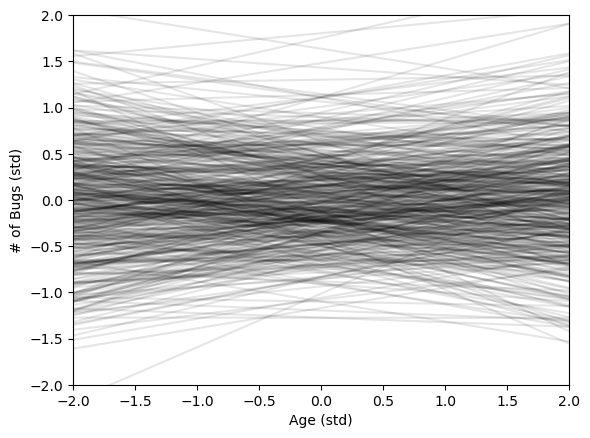

In [40]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
alpha_  = m_h2_idata.prior.alpha[0]
bA_ = m_h2_idata.prior.bA[0][:,0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = alpha_ + bA_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Age (std)")
ax.set_ylabel("# of Bugs (std)")
ax.set_ylim(-2.0, 2.0)
ax.set_xlim(-2.0, 2.0)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'bA'}>, <Axes: title={'center': 'bA'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

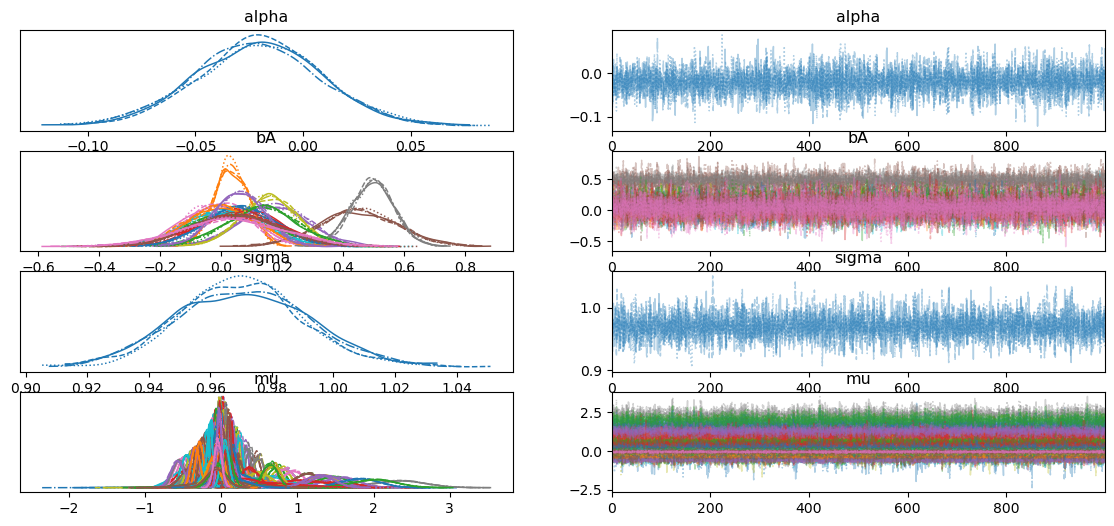

In [35]:
az.plot_trace(m_h2_idata, figsize=(14, 3*2))

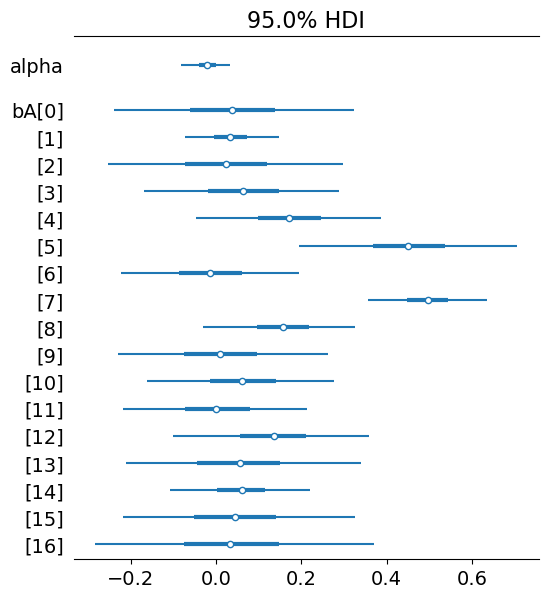

In [37]:
pm.plot_forest(m_h2_idata, var_names=['alpha','bA'], hdi_prob=.95, combined=True);

In [83]:
n_points = len(df)
x_seq = np.linspace(-1.5, 5, n_points)

with m_h2:
    pm.set_data({"age_std": x_seq, "language_ids": np.repeat(6, n_points)})
    post_pred_B = pm.sample_posterior_predictive(m_h2_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_B_mean = post_pred_B.mean(["chain", "draw"])

Sampling: [B]


In [75]:
df['language'].value_counts()

language
Javascript      202
Python          102
C++              86
C                82
Java             74
Ruby             67
Typescript       58
Php              57
Objective-C      56
Coffeescript     52
C#               51
Clojure          50
Scala            46
Erlang           42
Haskell          39
Go               38
Perl             25
Name: count, dtype: int64

In [73]:
languages

Index(['Clojure', 'Javascript', 'Objective-C', 'Java', 'Php', 'C#', 'Perl',
       'C', 'C++', 'Erlang', 'Haskell', 'Typescript', 'Ruby', 'Coffeescript',
       'Python', 'Go', 'Scala'],
      dtype='object')

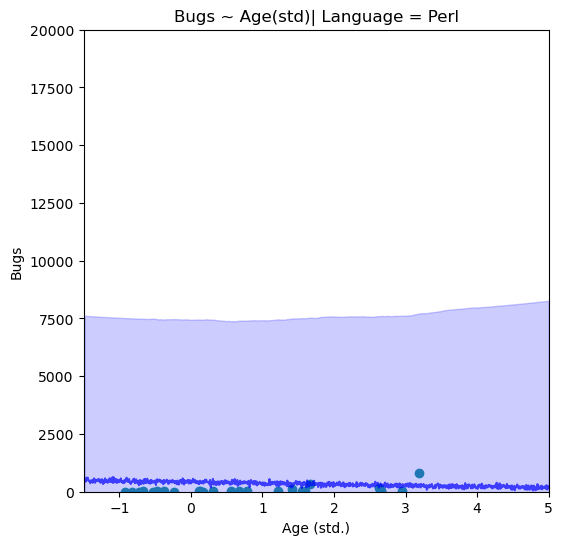

In [84]:
#_, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.figure(figsize=(6,6))

az.plot_hdi(x_seq, post_pred_B*df.bugs.std()+df.bugs.mean(), color = 'b', fill_kwargs={'alpha': 0.2}, ax=plt)
plt.plot(x_seq, post_pred_B_mean*df.bugs.std()+df.bugs.mean(), color = 'b', alpha=0.7, label='mean')
plt.scatter(df[df['language']=='Perl'].age_std, df[df['language']=='Perl'].bugs)


plt.xlim(-1.5,5.0)
plt.ylim(0,20000)
#plt.ylim(-3.0,3.0)
plt.xlabel('Age (std.)')
plt.ylabel('Bugs')
plt.title("Bugs ~ Age(std)| Language = Perl");